In [2]:

import kagglehub
borhanitrash_alzheimer_mri_disease_classification_dataset_path = kagglehub.dataset_download('borhanitrash/alzheimer-mri-disease-classification-dataset')

print('Data source import complete.')


100%|██████████| 26.0M/26.0M [00:00<00:00, 37.4MB/s]

Extracting files...


Data source import complete.


# **Imports and Setup**
First, we'll import the necessary libraries and set up the environment.

In [3]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import time
import os
from PIL import Image
import pyarrow.parquet as pq
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping

# Check TensorFlow version
print(f"TensorFlow version: {tf.__version__}")

# Set GPU configuration if available
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"Using GPU: {gpus[0].name}")
    except RuntimeError as e:
        print(e)
else:
    print("Using CPU")

TensorFlow version: 2.17.1
Using GPU: /physical_device:GPU:0


# **Data Loading and Preprocessing**
We'll load the data from the parquet files, decode the images, and prepare them for TensorFlow. The key here is to ensure that all images are stacked into a single NumPy array with a consistent shape.
* Load and Convert Images

In [6]:
import pandas as pd



# Download the dataset using kagglehub
dataset_path = kagglehub.dataset_download('borhanitrash/alzheimer-mri-disease-classification-dataset')
BASE_DIR = os.path.join(dataset_path, "Alzheimer MRI Disease Classification Dataset", "Data")

# Disease labels
disease_label_from_category = {
    0: "Mild Demented",
    1: "Moderate Demented",
    2: "Non Demented",
    3: "Very Mild Demented",
}

# Function to convert dictionary to image array
def dict_to_image(image_dict):
    if isinstance(image_dict, dict) and 'bytes' in image_dict:
        byte_string = image_dict['bytes']
        nparr = np.frombuffer(byte_string, np.uint8)
        img = cv2.imdecode(nparr, cv2.IMREAD_GRAYSCALE)
        return img
    else:
        raise TypeError(f"Expected dictionary with 'bytes' key, got {type(image_dict)}")

# Load training data
train_df = pd.read_parquet(f"{BASE_DIR}/train-00000-of-00001-c08a401c53fe5312.parquet", engine="pyarrow")
train_df['img_arr'] = train_df['image'].apply(dict_to_image)
train_df.drop("image", axis=1, inplace=True)

# Load test data
test_df = pd.read_parquet(f"{BASE_DIR}/test-00000-of-00001-44110b9df98c5585.parquet", engine="pyarrow")
test_df['img_arr'] = test_df['image'].apply(dict_to_image)
test_df.drop("image", axis=1, inplace=True)

print("Training and test data loaded successfully.")

Training and test data loaded successfully.


* Verify Image Shapes
> Before stacking the images, it's crucial to ensure that all images have the same dimensions. If not, we'll need to resize them.

In [7]:
# Check image shapes
train_image_shapes = train_df['img_arr'].apply(lambda x: x.shape).unique()
test_image_shapes = test_df['img_arr'].apply(lambda x: x.shape).unique()

print(f"Unique image shapes in training data: {train_image_shapes}")
print(f"Unique image shapes in test data: {test_image_shapes}")

Unique image shapes in training data: [(128, 128)]
Unique image shapes in test data: [(128, 128)]


* Stack Images into NumPy Arrays
> Convert the list of image arrays into a single NumPy array. This ensures that TensorFlow can handle the data efficiently.

In [8]:
# Convert lists of arrays to a single NumPy array
X_train = np.stack(train_df['img_arr'].values)  # Shape: (num_samples, 128, 128)
X_test = np.stack(test_df['img_arr'].values)    # Shape: (num_samples, 128, 128)

# Expand dimensions to add the channel dimension (grayscale)
X_train = X_train[..., np.newaxis]  # Shape: (num_samples, 128, 128, 1)
X_test = X_test[..., np.newaxis]    # Shape: (num_samples, 128, 128, 1)

# Extract labels
Y_train = train_df['label'].values
Y_test = test_df['label'].values

print(f"X_train shape: {X_train.shape}")
print(f"Y_train shape: {Y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"Y_test shape: {Y_test.shape}")

X_train shape: (5120, 128, 128, 1)
Y_train shape: (5120,)
X_test shape: (1280, 128, 128, 1)
Y_test shape: (1280,)


* Split Training Data into Training and Validation Sets

In [9]:
# Split training data into training and validation sets
X_train, X_val, Y_train, Y_val = train_test_split(
    X_train, Y_train, test_size=0.2, stratify=Y_train, random_state=42
)

print(f"Training set size: {X_train.shape[0]}")
print(f"Validation set size: {X_val.shape[0]}")

Training set size: 4096
Validation set size: 1024


* Normalize Images
> Normalize the pixel values to the [0,1] range.

In [10]:
# Normalize images
X_train = X_train.astype('float32') / 255.0
X_val = X_val.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

* Create TensorFlow Datasets
> Now that the data is properly formatted, create TensorFlow datasets.

In [11]:
# Parameters
N_CLASSES = len(np.unique(Y_train))
BATCH_SIZE = 32
EPOCHS = 10
LEARNING_RATE = 0.001

# Create TensorFlow datasets
train_ds = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
train_ds = train_ds.shuffle(buffer_size=1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices((X_val, Y_val))
val_ds = val_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

test_ds = tf.data.Dataset.from_tensor_slices((X_test, Y_test))
test_ds = test_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

* Analyze Class Distribution

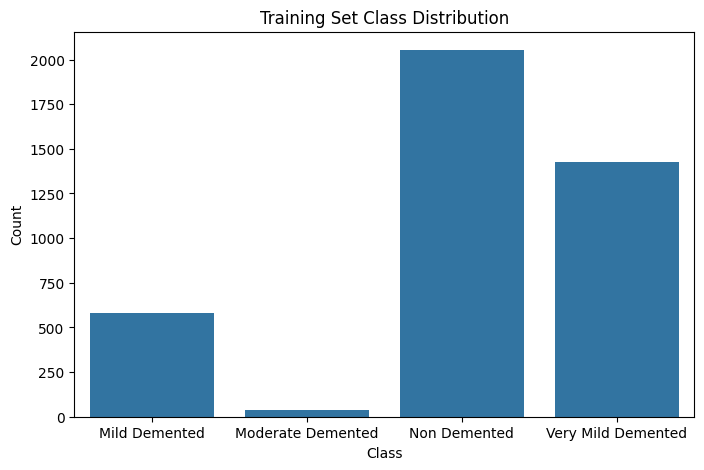

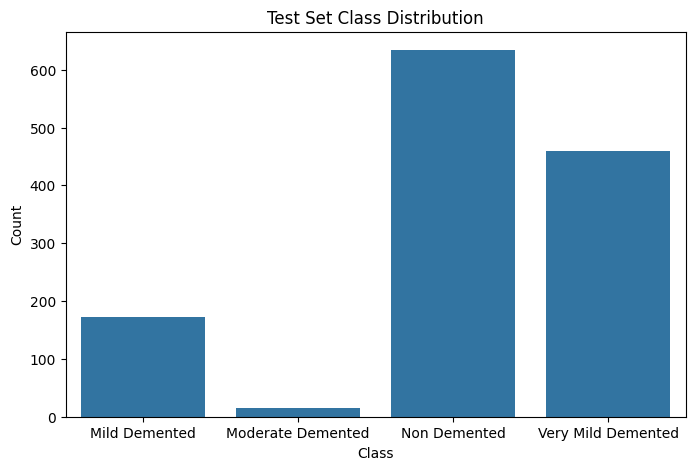

In [13]:
import seaborn as sns

# Function to plot class distribution
def plot_class_distribution(labels, title):
    plt.figure(figsize=(8,5))
    sns.countplot(x=labels)
    plt.title(title)
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.xticks(ticks=range(len(disease_label_from_category)),
               labels=[disease_label_from_category[i] for i in range(4)])
    plt.show()

# Plot distributions
plot_class_distribution(Y_train, "Training Set Class Distribution")
plot_class_distribution(Y_test, "Test Set Class Distribution")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 128, 128, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 64, 64, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 64, 64, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 32, 32, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 65536)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       8,388,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,408,452 (32.08 MB)

 Trainable params: 8,408,260 (32.07 MB)

 Non-trainable params: 192 (768.00 B)

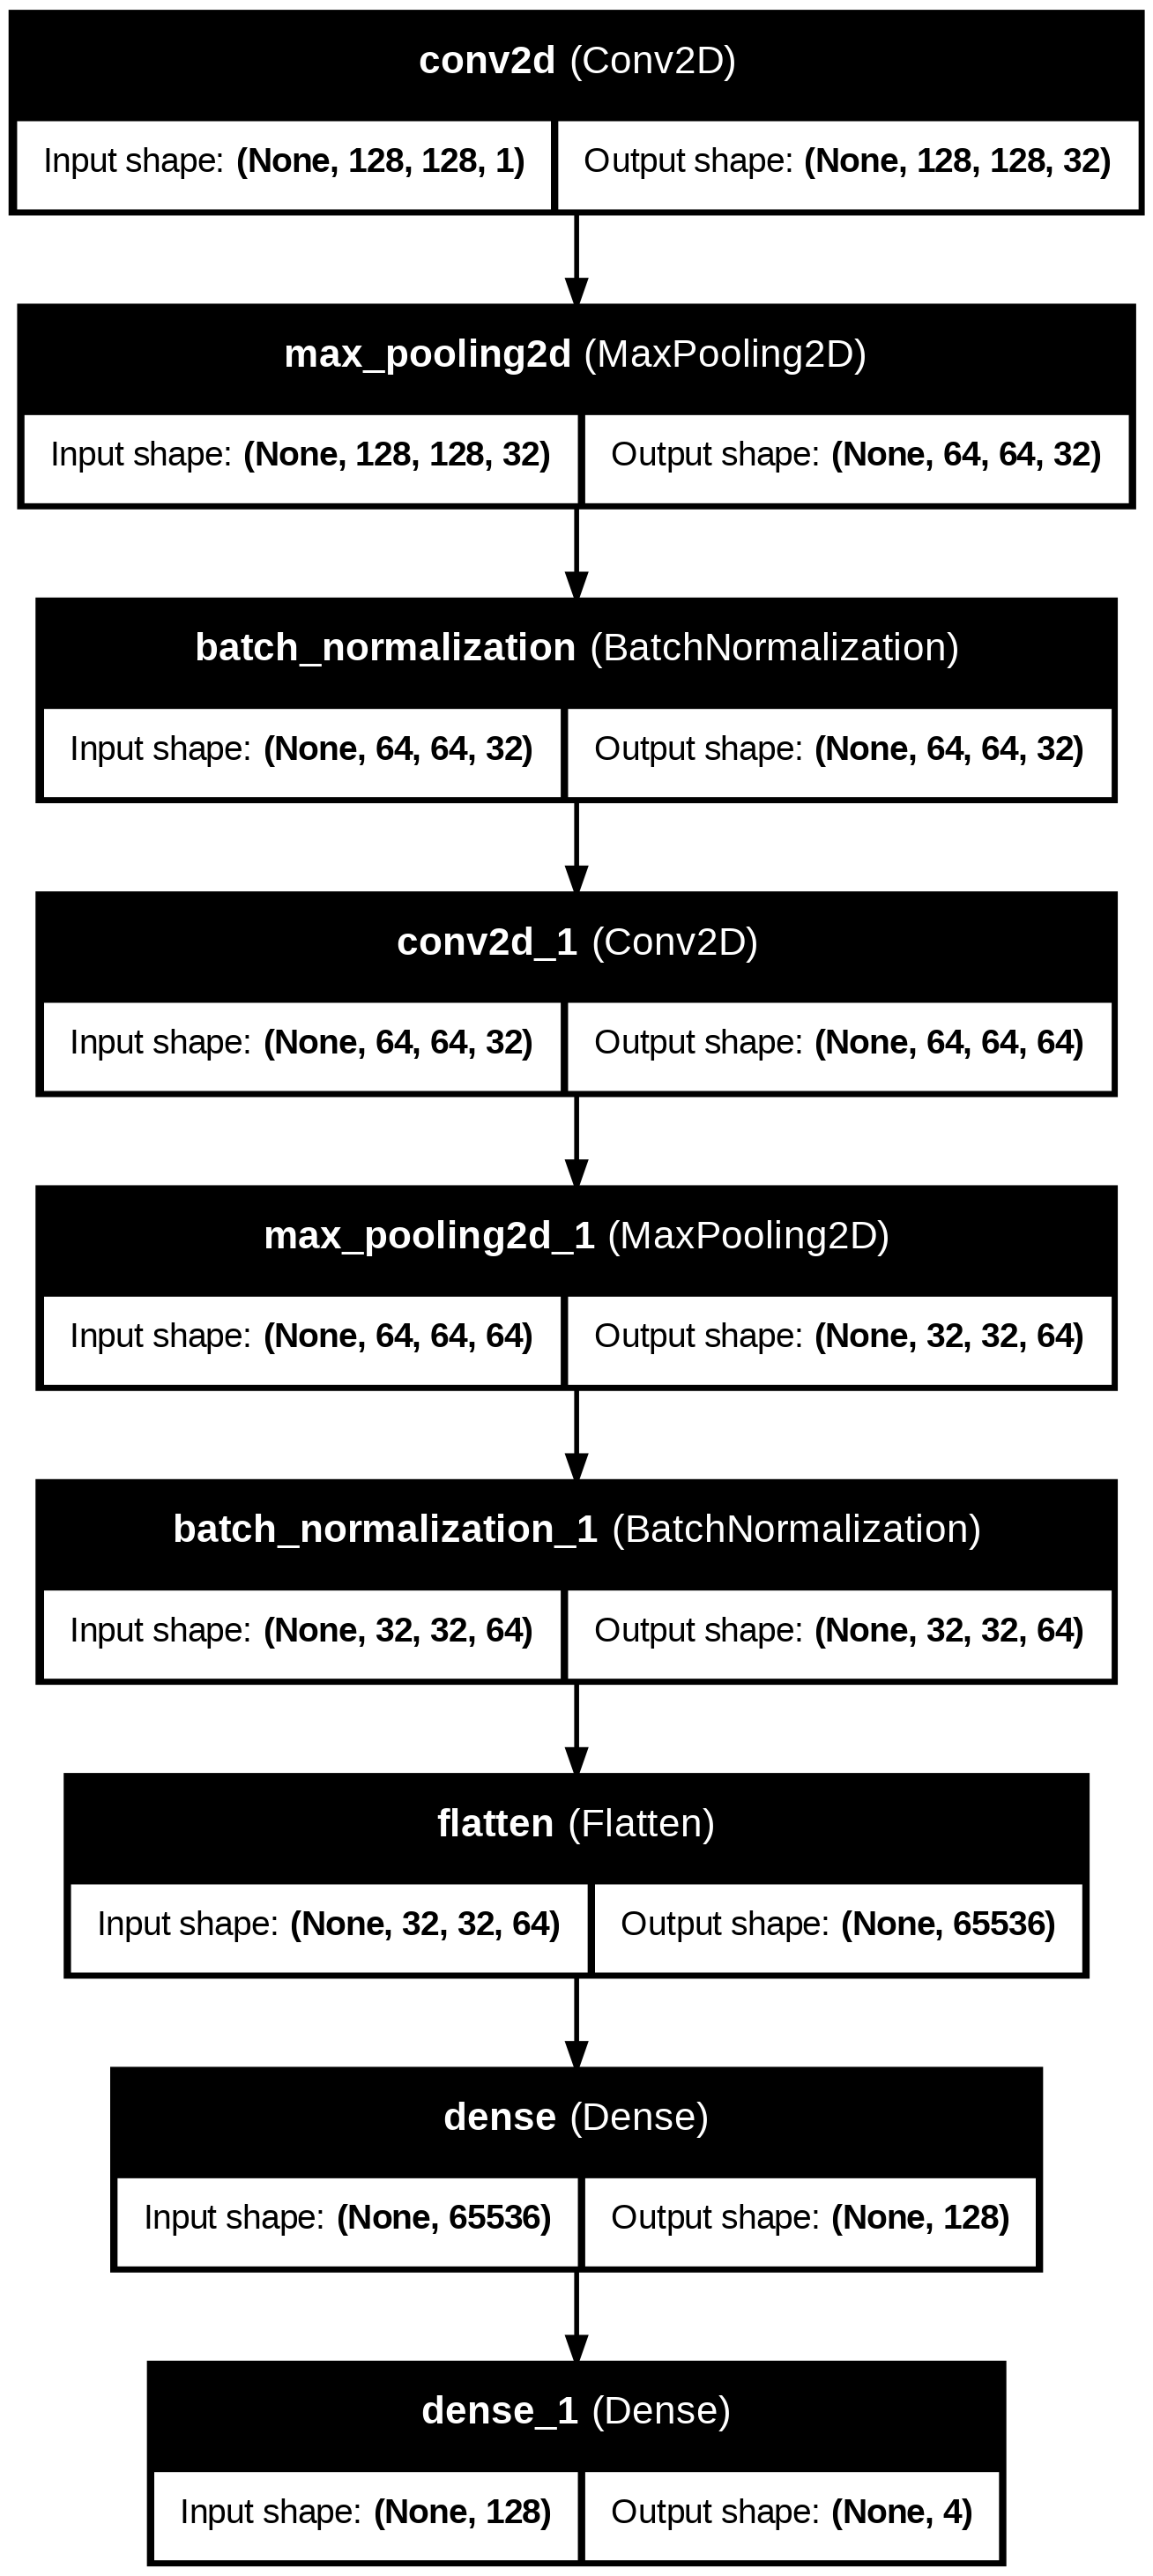

In [14]:
# Define the Baseline CNN model
def create_baseline_cnn(input_shape=(128, 128, 1), num_classes=4):
    model = models.Sequential([
        layers.Conv2D(32, (3,3), activation='relu', padding='same', input_shape=input_shape),
        layers.MaxPooling2D((2,2)),
        layers.BatchNormalization(),

        layers.Conv2D(64, (3,3), activation='relu', padding='same'),
        layers.MaxPooling2D((2,2)),
        layers.BatchNormalization(),

        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

baseline_cnn = create_baseline_cnn()
baseline_cnn.compile(optimizer=optimizers.Adam(learning_rate=LEARNING_RATE),
                     loss='sparse_categorical_crossentropy',
                     metrics=['accuracy'])

baseline_cnn.summary()

# Plot the model architecture
plot_model(baseline_cnn, show_shapes=True, show_layer_names=True)

* Training the Baseline Model

In [15]:
# Define callbacks
# Save the best model based on validation accuracy
checkpoint_cb = ModelCheckpoint(
    filepath="baseline_cnn.keras",  # File path to save the model
    save_best_only=True,            # Only save when the model is better
    monitor='val_accuracy',         # Metric to monitor
    mode='max',                     # Mode: 'max' for accuracy
    verbose=0                       # Verbosity mode
)
# Stop training when validation accuracy doesn't improve for 5 epochs
earlystop_cb = EarlyStopping(
    monitor='val_accuracy',         # Metric to monitor
    patience=5,                     # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True,      # Restore model weights from the epoch with the best value of the monitored metric
    mode='max',                     # Mode: 'max' for accuracy
    verbose=1                       # Verbosity mode
)

# Train the model
history_baseline = baseline_cnn.fit(
    train_ds,
    epochs=100,
    validation_data=val_ds,
    callbacks=[checkpoint_cb, earlystop_cb]
)

Epoch 1/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - accuracy: 0.4746 - loss: 8.9259 - val_accuracy: 0.5010 - val_loss: 2.2074
Epoch 2/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.7158 - loss: 0.7406 - val_accuracy: 0.5010 - val_loss: 3.1344
Epoch 3/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.7702 - loss: 0.5858 - val_accuracy: 0.5107 - val_loss: 3.0808
Epoch 4/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.9013 - loss: 0.2854 - val_accuracy: 0.5117 - val_loss: 1.6575
Epoch 5/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.9615 - loss: 0.1408 - val_accuracy: 0.6064 - val_loss: 0.9795
Epoch 6/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.9816 - loss: 0.0951 - val_accuracy: 0.8975 - val_loss: 0.2618
Epoch 7/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.9947 - loss: 0.0492 - val_accuracy: 0.9473 - val_loss: 0.1660
Epoch 8/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.9998 - loss: 0.0259 -

* Evaluation

In [16]:
# Load the best model
baseline_cnn.load_weights("baseline_cnn.keras")

# Evaluate on training data (not recommended for final evaluation)
train_predictions = baseline_cnn.predict(train_ds)
train_pred_labels = np.argmax(train_predictions, axis=1)
train_true_labels = Y_train

print("Training Accuracy:", accuracy_score(train_true_labels, train_pred_labels))
print("Confusion Matrix:")
print(confusion_matrix(train_true_labels, train_pred_labels))
print("\nClassification Report:")
print(classification_report(train_true_labels, train_pred_labels, target_names=[disease_label_from_category[i] for i in range(4)]))

# Evaluate on test data
test_predictions = baseline_cnn.predict(test_ds)
test_pred_labels = np.argmax(test_predictions, axis=1)
test_true_labels = Y_test

print("Test Accuracy:", accuracy_score(test_true_labels, test_pred_labels))
print("Confusion Matrix:")
print(confusion_matrix(test_true_labels, test_pred_labels))
print("\nClassification Report:")
print(classification_report(test_true_labels, test_pred_labels, target_names=[disease_label_from_category[i] for i in range(4)]))

128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Training Accuracy: 0.383544921875
Confusion Matrix:
[[  72    7  299  201]
 [   6    0   15   18]
 [ 310   16 1010  717]
 [ 191   16  729  489]]

Classification Report:
                    precision    recall  f1-score   support

     Mild Demented       0.12      0.12      0.12       579
 Moderate Demented       0.00      0.00      0.00        39
      Non Demented       0.49      0.49      0.49      2053
Very Mild Demented       0.34      0.34      0.34      1425

          accuracy                           0.38      4096
         macro avg       0.24      0.24      0.24      4096
      weighted avg       0.38      0.38      0.38      4096

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Test Accuracy: 0.975
Confusion Matrix:
[[162   0   3   7]
 [  0  14   0   1]
 [  1   0 619  14]
 [  0   0   6 453]]

Classification Report:
                    precision    recall  f1-score   support

     Mild Demented       0.99      0.94      0.97       172
 Modera